In [99]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
import pickle
from scipy.optimize import curve_fit
from lpu3dnet.post_process.kr_process import *
from sklearn.metrics import mean_squared_error, mean_absolute_error


root_dir = 'db'

def calculate_error_metrics(predictions, true_value, metric='mse'):
    """
    Calculate error metrics for a list of predictions against a true value.

    Args:
    predictions (list): List of prediction values.
    true_value (float): The true value to compare against.
    metric (str): Specify 'mse' for Mean Squared Error or 'mae' for Mean Absolute Error.

    Returns:
    float: The calculated error metric.
    """
    # Repeat the true value to match the length of predictions
    true_values = [true_value] * len(predictions)
    
    if metric == 'mse':
        return mean_squared_error(true_values, predictions)
    elif metric == 'mae':
        return mean_absolute_error(true_values, predictions)
    else:
        raise ValueError("Metric must be 'mse' or 'mae'")

def truncated_kr(df,corey_fit):
    swir = corey_fit.swirr
    sorg = corey_fit.sor

    # find largest krw and krnw
    krw_max = df['krw'].max()
    krnw_max = df['krnw'].max()
    # truncated df based on the krw and krnw
    df = df[ (df['krw']<krw_max) & (df['krnw']<krnw_max) ]
    # truncated kr based on the swir and sorg
    # make sure sw in the range of swir and 1-sorg
    # df = df[(df['sw']>=swir) & (df['sw']<=1-sorg)]
    return df

def truncated_kr(df,corey_fit):
    swir = corey_fit.swirr
    sorg = corey_fit.sor

    # find largest krw and krnw
    krw_max = df['krw'].max()
    krnw_max = df['krnw'].max()
    # truncated df based on the krw and krnw
    df = df[ (df['krw']<krw_max) & (df['krnw']<krnw_max) ]
    # truncated kr based on the swir and sorg
    # make sure sw in the range of swir and 1-sorg
    # df = df[(df['sw']>=swir) & (df['sw']<=1-sorg)]
    return df


def corey_process(sim_results,sample_idx):
    prediction = {'data':[],'par':[]}
    compare = {'data':[],'par':[]}
    num_pred = len(sim_results[sample_idx]['generate'])
    num_compare = len(sim_results['compare'])

    for i in range(num_pred):
        if sim_results[sample_idx]['generate'][i]:
            df_pred = convert_dict_to_pd(sim_results[sample_idx]['generate'][i])
            corey_fit = Corey_fit(df_pred)
            kr_avg_pred,par,criteria = corey_fit.generate_kr_data()
            if criteria:
                prediction['data'].append(kr_avg_pred)
                prediction['par'].append(par)
    


    for i in range(num_compare):
        if sim_results['compare'][i]:
            df_compare = convert_dict_to_pd(sim_results['compare'][i])
            corey_fit = Corey_fit(df_compare)
            kr_avg_compare,par,criteria = corey_fit.generate_kr_data()
            if criteria:
                compare['data'].append(kr_avg_compare)
                compare['par'].append(par)

    df_real = sim_results[sample_idx]['original']

    # fit the real data
    df_real = convert_dict_to_pd(df_real)
    corey_fit = Corey_fit(df_real)
    kr_real_corey,par_real,criteria = corey_fit.generate_kr_data()

    return prediction,compare,kr_real_corey,df_real


def calculate_errors(pred_list, real_array, error_type='mse'):
    """
    Calculate errors between each array in the prediction list and the real array.
    
    Parameters:
    - pred_list: list of numpy arrays, each with shape (100,)
    - real_array: numpy array with shape (100,)
    - error_type: 'mse' for Mean Squared Error, 'mae' for Mean Absolute Error
    
    Returns:
    - errors: list of error values
    """
    errors = []
    
    # Choose the error function based on the error_type
    error_func = mean_squared_error if error_type == 'mse' else mean_absolute_error
    
    for pred in pred_list:
        # Calculate error between the current prediction and the real array
        error = error_func(real_array, pred)
        errors.append(error)
    
    return errors

In [138]:
ct_idx = 5
vol_dim = 6

with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)



#### Calculate error of prediction comparing with reference

In [158]:
prediction,compare,kr_real_corey, df_real = corey_process(sim_results,1)
print(len(prediction['data']),len(compare['data']))

# for krw
krw_pred = [x['krw'].values for x in prediction['data']]
krnw_pred = [x['krnw'].values for x in prediction['data']]

krw_compare = [x['krw'].values for x in compare['data']]
krnw_compare = [x['krnw'].values for x in compare['data']]

krw_real = kr_real_corey['krw'].values
krnw_real = kr_real_corey['krnw'].values

krw_pred_mse = calculate_errors(krw_pred, krw_real, error_type='mae')
krnw_pred_mse = calculate_errors(krnw_pred, krnw_real, error_type='mae')

krw_compare_mse = calculate_errors(krw_compare, krw_real, error_type='mae')
krnw_compare_mse = calculate_errors(krnw_compare, krnw_real, error_type='mae')

print(np.mean(krw_pred_mse),np.mean(krnw_pred_mse))
print(np.mean(krw_compare_mse),np.mean(krnw_compare_mse))




1 25
0.10390569613171062 0.20876908360897384
0.11880543350434379 0.0909299314441302


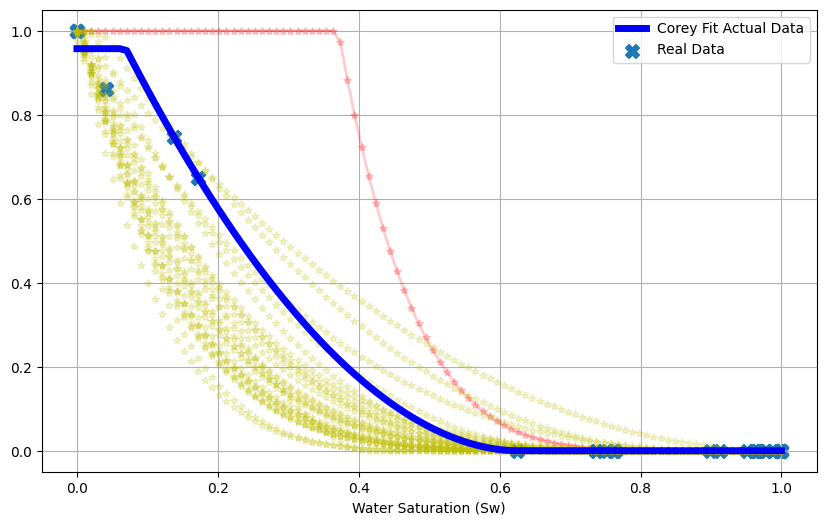

In [160]:
prediction_data = prediction['data']
compare_data = compare['data']

f = plt.figure(figsize=(10, 6))

for i in range(1):
    plt.plot(
        prediction_data[i]['sw'],
        prediction_data[i]['krnw'], 'r-*',linewidth=2,alpha=0.2
        )

for j in range(len(compare_data)):
    plt.plot(compare_data[j]['sw'],
            compare_data[j]['krnw'],
            'y*',
            linewidth=1,alpha=0.2
            )

plt.xlabel('Water Saturation (Sw)')
plt.plot(kr_real_corey['sw'], kr_real_corey['krnw'], color='blue',linewidth=5, label='Corey Fit Actual Data')
plt.scatter(df_real['sw'], df_real['kr_air'], s=100,marker='X',label='Real Data')
plt.grid(True)
plt.legend() 
plt.show()

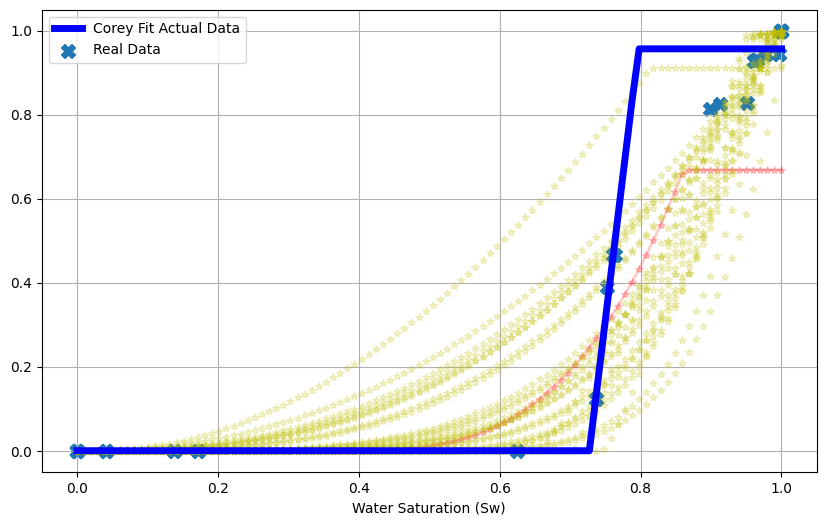

In [161]:
f = plt.figure(figsize=(10, 6))

for i in range(1):
    plt.plot(
        prediction_data[i]['sw'],
        prediction_data[i]['krw'], 'r-*',linewidth=2,alpha=0.2
        )

for j in range(len(compare_data)):
    plt.plot(compare_data[j]['sw'],
            compare_data[j]['krw'],
            'y*',
            linewidth=1,alpha=0.2
            )

plt.xlabel('Water Saturation (Sw)')
plt.plot(kr_real_corey['sw'], kr_real_corey['krw'], color='blue',linewidth=5, label='Corey Fit Actual Data')
plt.scatter(df_real['sw'], df_real['kr_water'], s=100,marker='X',label='Real Data')
plt.grid(True)
plt.legend() 
plt.show()

In [ ]:
# prediction = {'data':[],'par':[]}
# compare = {'data':[],'par':[]}

# sample_idx = 2


# for i in range(num_pred):
#     if sim_results[sample_idx]['generate'][i]:
#         df_pred = convert_dict_to_pd(sim_results[sample_idx]['generate'][i])
#         corey_fit = Corey_fit(df_pred)
#         kr_avg_pred,par,criteria = corey_fit.generate_kr_data()
#         if criteria:
#             prediction['data'].append(kr_avg_pred)
#             prediction['par'].append(par)
    


# for i in range(num_compare):
#     if sim_results['compare'][i]:
#         df_compare = convert_dict_to_pd(sim_results['compare'][i])
#         corey_fit = Corey_fit(df_compare)
#         kr_avg_compare,par,criteria = corey_fit.generate_kr_data()
#         if criteria:
#             compare['data'].append(kr_avg_compare)
#             compare['par'].append(par)

# df_real = sim_results[sample_idx]['original']

# # fit the real data
# df_real = convert_dict_to_pd(df_real)
# corey_fit = Corey_fit(df_real)
# kr_real_corey,par_real,criteria = corey_fit.generate_kr_data()